In [1]:
# Library Imports
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from random import randint
import random
from tqdm.notebook import trange
import math
#from pytictoc import TicToc

class Bandit:
    def __init__(self, k_arm=10, epsilon=0., initial=0., step_size=0.1, sample_averages=False, UCB_param=None,
                     gradient=False, gradient_baseline=False, true_reward=0., true_prob=0, step_count=100,
                 Bernouli=False, Normal=False, Gauss=False,
                 GreedyTS=False, GeneralTS=False, LaplaceTS=False, BootTS=False, LangevinTS=False):
            self.k = k_arm
            self.step_size = step_size
            self.sample_averages = sample_averages
            self.indices = np.arange(self.k)
            self.time = 0
            self.UCB_param = UCB_param
            self.gradient = gradient
            self.gradient_baseline = gradient_baseline
            self.average_reward = 0
            self.true_reward = true_reward
            self.epsilon = epsilon
            self.initial = initial
            self.true_prob = np.array(true_prob)
            self.step_count = step_count
            self.random_reward_flag = 0;
            
            self.Bernouli = Bernouli
            self.Normal = Normal
            self.Gauss = Gauss
            
            self.GreedyTS = GreedyTS
            self.GeneralTS = GeneralTS
            self.LaplaceTS = LaplaceTS
            self.BootTS = BootTS
            self.LangevinTS = LangevinTS

            self.theta = np.random.uniform(0, 1, self.k)     
    
    def name(self):
        if (self.Bernouli):
            return 'Bernouli-Distribution'
        if (self.Normal):
            return 'Normal-Distribution'
        if (self.Gauss):
            return 'Gaussian-Distribution'
    
    def Type(self):
        if(self.UCB_param is not None):
            return 'UCB'
        elif(self.gradient):
            return 'Gradient_Adscent'
        elif(self.GreedyTS):
            return 'Greedy_TS: {}'.format(self.epsilon)
        elif(self.GeneralTS):
            return 'General_TS'
        elif(self.epsilon != 0):
            return 'Epsilon_Greedy: {}'.format(self.epsilon)
        elif(self.Gauss):
            return 'Gaussian'
        elif(self.LaplaceTS):
            return 'Laplace TS'
        elif(self.BootTS):
            return 'Bootstrape TS'
        elif(self.LangevinTS):
            return 'Langevin TS'
        else:
            return 'Optimistic'

    def reset(self):
            # real reward for each action
            self.q_true = np.random.randn(self.k) + self.true_reward

            # estimation for each action
            self.q_estimation = np.zeros(self.k) + self.initial

            # # of chosen times for each action
            self.action_count = np.zeros(self.k)
            
            self.true_prob = np.random.rand(self.k)
            
            assert np.all(self.theta >= 0)
            assert np.all(self.theta <= 1)
            
            self.best_action = np.argmax(self.true_prob)
                
            self.alpha = np.ones(self.k)
            self.beta = np.ones(self.k)

            self.time = 0

    def action(self):
            if np.random.rand() < self.epsilon:
                return np.random.choice(self.indices)

            if self.UCB_param is not None:
                UCB_estimation = self.q_estimation + \
                    self.UCB_param * np.sqrt(np.log(self.time + 1) / (self.action_count + 1e-5))
                q_best = np.max(UCB_estimation)
                return np.random.choice(np.where(UCB_estimation == q_best)[0])

            if self.gradient:
                exp_est = np.exp(self.q_estimation)
                self.action_prob = exp_est / np.sum(exp_est)
                return np.random.choice(self.indices, p=self.action_prob)
            
            q_best = np.max(self.q_estimation)
            return np.random.choice(np.where(self.q_estimation == q_best)[0])

    def step(self, action):
       
            # Normal Distribution reward
            if (self.Normal):
                reward = self.true_prob[action]
            
            # Bernouli Distribution reward
            if (self.Bernouli):            

               reward = np.random.binomial(1, self.true_prob[action]) 
            
            if(self.Gauss):
                reward = random.gauss(self.mean[action], self.std_dev[action])

            self.time += 1
            self.action_count[action] += 1
            self.average_reward += (reward - self.average_reward) / self.time

            if self.sample_averages:
                # update estimation using sample averages
                self.q_estimation[action] += (reward - self.q_estimation[action]) / self.action_count[action]
                
            elif self.gradient:
                one_hot = np.zeros(self.k)
                one_hot[action] = 1
                if self.gradient_baseline:
                    baseline = self.average_reward
                else:
                    baseline = 0
                self.q_estimation += self.step_size * (reward - baseline) * (one_hot - self.action_prob)
                    
            else:
                # update estimation with constant step size
                self.q_estimation[action] += self.step_size * (reward - self.q_estimation[action])
                
                
            regret = (self.true_prob).max() - self.true_prob[action]
            return reward, regret

In [2]:
def simulate(runs, time, bandits):
    rewards = np.zeros((len(bandits), runs, time))
    best_action_counts = np.zeros(rewards.shape)
    regrets = np.zeros(rewards.shape)
    
    for i, bandit in enumerate(bandits):
        for r in trange(runs, desc=bandit.name() + ' ' + bandit.Type()):
            bandit.reset()
            
            # regrets = np.zeros(time)
            for t in range(time):
                action = bandit.action()
                reward, regret = bandit.step(action)
                rewards[i, r, t] = reward
                regrets[i, r, t] = regret
                if action == bandit.best_action:
                    best_action_counts[i, r, t] = 1
    mean_best_action_counts = best_action_counts.mean(axis=1)
    mean_rewards = rewards.mean(axis=1)
    mean_regret = regrets.mean(axis=1)
    return mean_best_action_counts, mean_rewards, mean_regret

In [3]:
runs = 5000
time = 1000

labels = ['greedy 0.1', 'greedy 0.01', 'UCB 0',
               'UCB 0.5', 'UCB 1', 'UCB 2']

bandits = []

bandits.append(Bandit(epsilon = 0.1, Normal=True, sample_averages=True))
bandits.append(Bandit(epsilon = 0.01, Normal=True, sample_averages=True))

bandits.append(Bandit(UCB_param=0, Normal=True, sample_averages=True))
bandits.append(Bandit(UCB_param=0.5, Normal=True, sample_averages=True))
bandits.append(Bandit(UCB_param=1, Normal=True, sample_averages=True))
bandits.append(Bandit(UCB_param=2, Normal=True, sample_averages=True))

avg_optimal, average_rewards_1, avg_regret_1 = simulate(runs, time, bandits)
rewards_1 = np.mean(average_rewards_1, axis=1)


Normal-Distribution Epsilon_Greedy: 0.1:   0%|          | 0/5000 [00:00<?, ?it/s]

Normal-Distribution Epsilon_Greedy: 0.01:   0%|          | 0/5000 [00:00<?, ?it/s]

Normal-Distribution UCB:   0%|          | 0/5000 [00:00<?, ?it/s]

Normal-Distribution UCB:   0%|          | 0/5000 [00:00<?, ?it/s]

Normal-Distribution UCB:   0%|          | 0/5000 [00:00<?, ?it/s]

Normal-Distribution UCB:   0%|          | 0/5000 [00:00<?, ?it/s]

In [4]:
 avg_regret_1.shape
labels = ['greedy 0.1', 'greedy 0.01', 'UCB 0',
               'UCB 0.5', 'UCB 1', 'UCB 2']

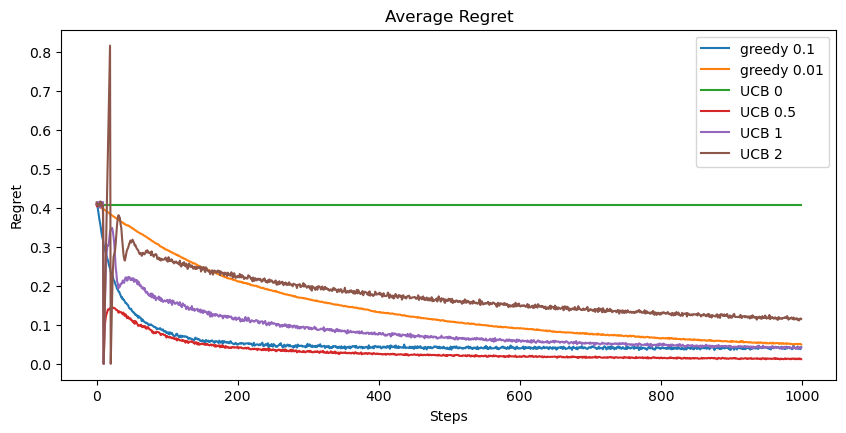

In [5]:
plt.figure(figsize=(10, 10))
plt.subplot(2,1,1)
x = np.arange(avg_regret_1[0].size)

for i,y in enumerate (avg_regret_1):
    plt.plot(x, y, label=labels[i])
    # plt.plot(x, y, 'o', markersize=2, label=labels[i])

plt.legend(loc='upper right')
plt.title('Average Regret')
plt.ylabel('Regret')
plt.xlabel('Steps') 
plt.show()

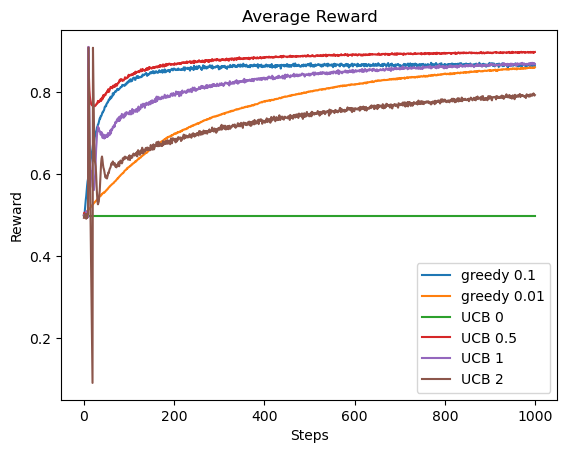

In [6]:
for i,y in enumerate (average_rewards_1):
    x = np.arange(average_rewards_1[i].size)
    plt.plot(x, y, label=labels[i])
plt.title('Average Reward')
plt.ylabel('Reward')
plt.xlabel('Steps')
plt.legend(loc='lower right')
plt.show()

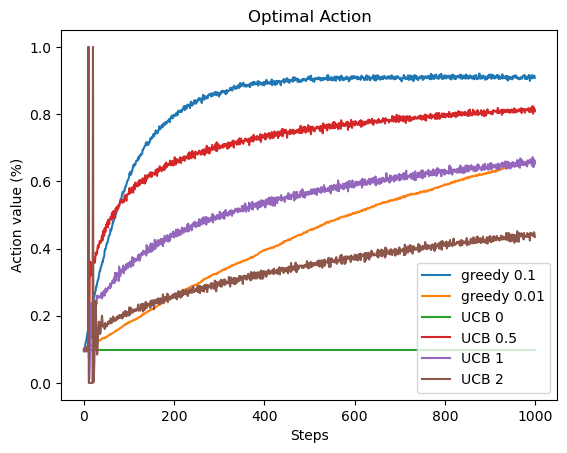

In [7]:
for i,y in enumerate (avg_optimal):
    x = np.arange(avg_optimal[i].size)
    plt.plot(x, y, label=labels[i])
plt.title('Optimal Action')
plt.ylabel('Action value (%)')
plt.xlabel('Steps')
plt.legend(loc='lower right')
plt.show()